# Votos por sesión

In [119]:
#Import
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import regex as re
import mlflow
import os

In [120]:
#Warnings
import warnings
warnings.filterwarnings("ignore")

In [121]:
def ordenar_por_digito(lista):
    # Genera una lista con los números extraídos después de la 'E' en cada cadena
    numeros = [int(re.search(r'E(\d+)', cadena).group(1)) if re.search(r'E(\d+)', cadena) else float('inf') for cadena in lista]
    
    # Crea una lista de índices de la lista original
    indices = list(range(len(lista)))
    
    # Ordena los índices según los valores numéricos en 'numeros'
    indices_ordenados = sorted(indices, key=lambda i: numeros[i])
    
    # Genera la lista ordenada usando los índices ordenados
    lista_ordenada = [lista[i] for i in indices_ordenados]
    
    return lista_ordenada

In [122]:
#Leyendo carpeta
folder = '../data/votos_procesado/sesion_54'
#Selecting csv files
files = [f for f in os.listdir(folder) if f.endswith('.csv')]
#Reading and concatenating
df = pd.concat([pd.read_csv(f'{folder}/{f}') for f in files], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   No.           480 non-null    int64 
 1   NOMBRE        480 non-null    object
 2   BLOQUE        480 non-null    object
 3   VOTO EMITIDO  480 non-null    object
 4   Evento        480 non-null    int64 
 5   Estampa       480 non-null    object
 6   Sesion        480 non-null    int64 
 7   Votacion      480 non-null    object
dtypes: int64(3), object(5)
memory usage: 30.1+ KB


In [123]:
df.head()

,No.,NOMBRE,BLOQUE,VOTO EMITIDO,Evento,Estampa,Sesion,Votacion
0,1,Luis Fernando Aguirre Estrada,CABAL,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...
1,2,Hellen Magaly Alexandrá Ajcip Canel,COMUNIDAD ELEFANTE,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...
2,3,Manuel Geovany Alvarado Vásquez,VAMOS POR UNA GUATEMALA DIFERENTE,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...
3,4,Manuel de Jesús Archila Cordón,CABAL,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...
4,5,Jorge Estuardo Ayala Marroquín,PARTIDO VALOR,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...


In [124]:
#Basic Validations
#Verifying nulls
print(f"Sum of nulls: {df.isnull().sum().sum()}")
#Counting registries
registries_per_event = df.groupby(['Evento', 'Estampa', 'Sesion']).count()
#Unique counts
print(f"Unique values: {registries_per_event['VOTO EMITIDO'].unique()}")
registries_per_event.head()


Sum of nulls: 0
Unique values: [160]


,,,No.,NOMBRE,BLOQUE,VOTO EMITIDO,Votacion
Evento,Estampa,Sesion,,,,,
42,26-11-2024 23:11:20,54,160,160,160,160,160
43,26-11-2024 23:11:31,54,160,160,160,160,160
44,26-11-2024 23:11:21,54,160,160,160,160,160


In [125]:
#Saving nulls
df_nulls = df[df.isnull().any(axis=1)]
df_nulls.to_csv('../data/votos_procesado/temp/nulls.csv', index=False)

In [126]:
#Validate this use
df = df.dropna()

In [127]:
#Events translator
df['Event_Key'] = 'S' + df['Sesion'].astype(str) + '_' + 'E' + df['Evento'].astype(str)
events = df[['Sesion','Evento','Votacion','Event_Key']].drop_duplicates().sort_values(['Sesion','Evento'])
print(f"Len: {len(events)}")
events.head()

Len: 3


,Sesion,Evento,Votacion,Event_Key
320,54,42,AL PROYECTO DE ACUERDO QUE DISPONE APROBAR PRE...,S54_E42
160,54,43,DEL PUNTO TERCERO DEL PROYECTO DE ACUERDO QUE ...,S54_E43
0,54,44,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44


In [128]:
#Saving events
events.to_csv('../data/votos_procesado/temp/events.csv', index=False)

In [129]:
#Validando conteo de eventos
vote_types_df = df[['Event_Key','VOTO EMITIDO']].groupby(['Event_Key','VOTO EMITIDO']).count()
vote_types_df.to_csv('../data/votos_procesado/transformed/votes_types_S43.csv')
vote_types_df.head()

Empty DataFrame
Columns: []
Index: [(S54_E42, A FAVOR), (S54_E42, AUSENTE), (S54_E42, EN CONTRA), (S54_E42, LICENCIA), (S54_E43, A FAVOR)]

In [130]:
#Filtering by single event
event = 'S54_E44'
df = df[df['Event_Key'] == event]
df.head()

,No.,NOMBRE,BLOQUE,VOTO EMITIDO,Evento,Estampa,Sesion,Votacion,Event_Key
0,1,Luis Fernando Aguirre Estrada,CABAL,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
1,2,Hellen Magaly Alexandrá Ajcip Canel,COMUNIDAD ELEFANTE,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
2,3,Manuel Geovany Alvarado Vásquez,VAMOS POR UNA GUATEMALA DIFERENTE,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
3,4,Manuel de Jesús Archila Cordón,CABAL,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
4,5,Jorge Estuardo Ayala Marroquín,PARTIDO VALOR,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44


In [131]:
#
df_to_pivot = df.copy()
df_pivoted = df_to_pivot.pivot(index = 'NOMBRE', columns = 'Event_Key', values = 'VOTO EMITIDO')
pivoted_columns = ordenar_por_digito(df_pivoted.columns)
df_pivoted = df_pivoted[pivoted_columns]
df_pivoted.head()

Event_Key,S54_E44
NOMBRE,
Alberto Eduardo De León Benítez,EN CONTRA
Allan Estuardo Rodríguez Reyes,EN CONTRA
Alma Luz Guerrero de la Cruz,EN CONTRA
Alvaro Enrique Arzú Escobar,EN CONTRA
Ana Lucrecia Marroquín Godoy de Palomo,EN CONTRA


In [132]:
#Guardando conjuntos de datos
df_pivoted.to_csv('../data/votos_procesado/transformed/pivoted_data_S54.csv')

## Grouping by votes

In [133]:
#Aplicando OHE a todas las columnas
df_ohe = pd.get_dummies(df_pivoted).astype('int')
df_ohe.head()

,S54_E44_A FAVOR,S54_E44_AUSENTE,S54_E44_EN CONTRA,S54_E44_LICENCIA
NOMBRE,,,,
Alberto Eduardo De León Benítez,0,0,1,0
Allan Estuardo Rodríguez Reyes,0,0,1,0
Alma Luz Guerrero de la Cruz,0,0,1,0
Alvaro Enrique Arzú Escobar,0,0,1,0
Ana Lucrecia Marroquín Godoy de Palomo,0,0,1,0


In [134]:
# Función para entrenar KMeans con un valor específico de k
def train_kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    labels = kmeans.labels_
    return kmeans, labels

# Función para calcular métricas
def calculate_metrics(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    # Puedes agregar más métricas si lo deseas
    return silhouette_avg

In [135]:
def run_experiment(data, experiment_name = "", run_prefix=""):
    # Configurar el experimento en MLflow
    mlflow.set_experiment(experiment_name)
    
    # Cargar datos
    #data = load_data()
    
    # Asegúrate de que 'data' sea una matriz numpy o dataframe sin etiquetas
    # Si 'data' incluye etiquetas o columnas no numéricas, debes preprocesarla adecuadamente
    
    for k in range(2, 16):
        with mlflow.start_run(run_name=f"{run_prefix}_KMeans_k={k}"):
            # Registrar el parámetro k
            mlflow.log_param("k", k)
            
            # Entrenar el modelo
            kmeans_model, labels = train_kmeans(data, k)
            
            # Calcular métricas
            silhouette_avg = calculate_metrics(data, labels)
            
            # Registrar métricas
            mlflow.log_metric("silhouette_score", silhouette_avg)
            
            # Opcional: guardar el modelo
            # mlflow.sklearn.log_model(kmeans_model, f"kmeans_model_k_{k}")
            
            # Si deseas guardar otros artefactos, como gráficos, puedes hacerlo aquí
            # Por ejemplo, guardar los clusters asignados
            cluster_assignments = pd.DataFrame({'Cluster': labels})
            cluster_assignments.to_csv('cluster_assignments.csv', index=False)
            mlflow.log_artifact('cluster_assignments.csv')
            
            # Limpiar archivos temporales
            import os
            os.remove('cluster_assignments.csv')

            # Concluir mlflow monitoreo
            mlflow.end_run()

In [136]:
#Training
X = df_ohe.values
run_experiment(X, "Congreso_Clustering_S54", "S54")

In [137]:
#Colors
color_dict = {
    'csj': (0.0, 0.447, 0.701),   # Azul
    'ca': (0.902, 0.624, 0.0),   # Naranja
    'congreso': (0.0, 0.619, 0.451),   # Verde
    'aqua': (0.337, 0.706, 0.914),   # Azul claro
    'naranja_aqua': (1.0, 0.498, 0.055),   # Naranja claro
    'une': (57/255,159/255,25/255)
}

In [138]:
#Determinando K para KMedioids
def plot_silhouette_vs_k(experiment_name, color=(0, 0, 1), font='Arial', title='Gráfica de Silhouette vs Grupos'):
    # Configurar el experimento de MLflow
    client = mlflow.tracking.MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    
    # Obtener las corridas (runs) del experimento
    runs = client.search_runs(experiment_ids=[experiment.experiment_id], order_by=["attributes.start_time DESC"])

    # Filtrar los datos para silhouette score y k
    data = []
    for run in runs:
        try:
            k = int(run.data.params['k'])  # Asumiendo que 'k' está guardado como parámetro
            silhouette = float(run.data.metrics['silhouette_score'])  # Asumiendo que el score está guardado como métrica
            data.append({'k': k, 'silhouette_score': silhouette})
        except KeyError:
            continue  # Ignorar las corridas que no tengan los parámetros o métricas esperadas
    
    # Convertir los datos a un DataFrame
    df = pd.DataFrame(data)
    df = df.sort_values(by='k')

    # Crear la gráfica
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(df['k'], df['silhouette_score'], color=color, linestyle='--', alpha=0.5)
    ax.plot(df['k'], df['silhouette_score'], 'o', color=color, markersize=8)

    # Graficando mayor
    max_index = df['silhouette_score'].idxmax()
    ax.plot(df['k'][max_index], df['silhouette_score'][max_index], 'o', color=color_dict['naranja_aqua'], markersize=10)

    # Configuración de los ejes
    ax.set_xlabel('grupo', fontname=font, fontsize=12)
    ax.set_ylabel('calidad de grupos', fontname=font, fontsize=12)
    
    # Estilo de los ejes: mostrar solo las líneas de los ejes X e Y
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Mantener el eje X en la parte inferior
    ax.spines['bottom'].set_visible(True)  # Asegurar que se muestra
    ax.spines['left'].set_position(('outward', 0))  # Eje Y alineado a la izquierda

    # Cambiar el color de los ejes a un gris claro
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    # Opcionalmente, puedes cambiar también el color de los ticks (marcas en los ejes)
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')

    # Cambiar el color de las etiquetas de los ejes a gris medio
    ax.xaxis.label.set_color('gray')
    ax.yaxis.label.set_color('gray')

    #Ticks de 1 en 1
    ax.set_xticks(range(2, 16))

    # Cambiar el color del título a gris medio
    ax.title.set_color('gray')
    
    # Ocultar la cuadrícula
    ax.grid(False)

    # Hacer que la gráfica ocupe todo el espacio sin margenes
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # Título
    plt.title(title, fontname=font, fontsize=16, color='gray')

    # Mostrar la gráfica
    plt.show()


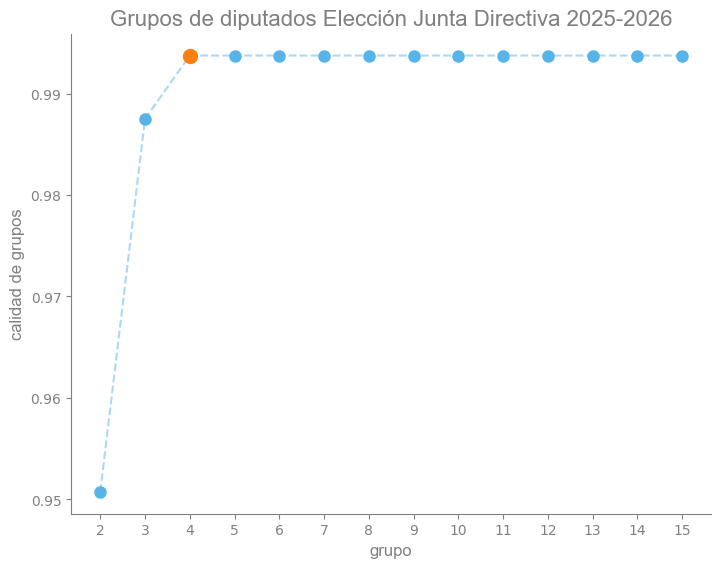

In [139]:
plot_silhouette_vs_k("Congreso_Clustering_S43", color=color_dict['aqua'], title='Grupos de diputados Elección Junta Directiva 2025-2026')

In [140]:
#Agregando etiquetas
max_k = 4
kmeans_model, labels = train_kmeans(X, max_k)
df_ohe['Grupo'] = labels
df_ohe.head()

,S54_E44_A FAVOR,S54_E44_AUSENTE,S54_E44_EN CONTRA,S54_E44_LICENCIA,Grupo
NOMBRE,,,,,
Alberto Eduardo De León Benítez,0,0,1,0,0
Allan Estuardo Rodríguez Reyes,0,0,1,0,0
Alma Luz Guerrero de la Cruz,0,0,1,0,0
Alvaro Enrique Arzú Escobar,0,0,1,0,0
Ana Lucrecia Marroquín Godoy de Palomo,0,0,1,0,0


In [141]:
#Asigning groups to pivoted df
df_pivoted['Grupo'] = labels
df_pivoted.head()

Event_Key,S54_E44,Grupo
NOMBRE,,
Alberto Eduardo De León Benítez,EN CONTRA,0
Allan Estuardo Rodríguez Reyes,EN CONTRA,0
Alma Luz Guerrero de la Cruz,EN CONTRA,0
Alvaro Enrique Arzú Escobar,EN CONTRA,0
Ana Lucrecia Marroquín Godoy de Palomo,EN CONTRA,0


In [142]:
df_pivoted['Event_Key'] = df_pivoted.index
df_pivoted.head()

Event_Key,S54_E44,Grupo,Event_Key
NOMBRE,,,
Alberto Eduardo De León Benítez,EN CONTRA,0,Alberto Eduardo De León Benítez
Allan Estuardo Rodríguez Reyes,EN CONTRA,0,Allan Estuardo Rodríguez Reyes
Alma Luz Guerrero de la Cruz,EN CONTRA,0,Alma Luz Guerrero de la Cruz
Alvaro Enrique Arzú Escobar,EN CONTRA,0,Alvaro Enrique Arzú Escobar
Ana Lucrecia Marroquín Godoy de Palomo,EN CONTRA,0,Ana Lucrecia Marroquín Godoy de Palomo


In [143]:
#df pivoted
df_pivoted_group = df_pivoted.reset_index()[['Event_Key',event]].groupby(event).count()
df_pivoted_group.columns

Index(['Event_Key'], dtype='object', name='Event_Key')

In [144]:
def plot_voting_results(df, font='Arial', title='Resultado de la Votación'):
    # Ordenar las filas por los valores, de mayor a menor
    df_sorted = df.sort_values(by='Event_Key', ascending=False)

    # Definir colores por tipo de voto
    color_mapping = {
        'A FAVOR': 'green',
        'EN CONTRA': 'red',
        'AUSENTE': 'gray',
        'LICENCIA': 'gray'
    }

    # Asignar colores basados en el índice
    colors = [color_mapping.get(idx, 'gray') for idx in df_sorted.index]

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Crear la gráfica de barras
    ax.bar(df_sorted.index, df_sorted['Event_Key'], color=colors, alpha=0.9)

    # Añadir el valor de cada barra encima de las barras
    for index, value in enumerate(df_sorted['Event_Key']):
        ax.text(index, value + 0.5, str(value), ha='center', va='bottom', color='black', fontname=font, fontsize=12)

    # Configuración de los ejes
    ax.set_xlabel('Tipo de Voto', fontname=font, fontsize=12)
    ax.set_ylabel('Cantidad', fontname=font, fontsize=12)

    # Estilo de los ejes: mostrar solo las líneas de los ejes X e Y
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    # Cambiar el color de los ticks y etiquetas
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')

    # Título
    plt.title(title, fontname=font, fontsize=16, color='gray')

    # Ajustar los márgenes
    plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.2)

    # Mostrar la gráfica
    plt.show()

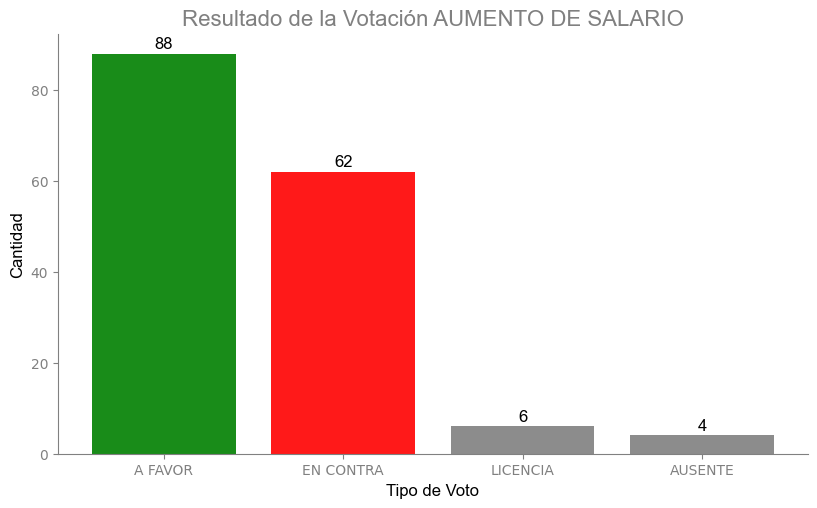

In [145]:
#Voting results
df_pivoted_group = df_pivoted.reset_index()[['Event_Key',event]].groupby(event).count()
plot_voting_results(df_pivoted_group, title='Resultado de la Votación AUMENTO DE SALARIO', font='Arial')

In [146]:
diputados_independientes = df[df['BLOQUE'] == 'INDEPENDIENTES']['NOMBRE'].drop_duplicates()
print(f"Len Independientes: {len(diputados_independientes)}")
#diputados_independientes.to_csv('../data/votos_procesado/temp/independientes.csv', encoding = 'latin-1')
diputados_independientes.head()


Len Independientes: 25


62            Rudy Berner Pereira Delgado
65       Vivian Beatriz Preciado Navarijo
92            Raúl Amilcar Barrera Robles
95           Luis Antonio Cáceres Gamarro
96    Manfredo Duvalier Castañón González
Name: NOMBRE, dtype: object

In [147]:
#AGREGANDO PARTIDOS A PIVOTED
indeps_partidos = pd.read_csv('../data/votos_procesado/temp/independientes.csv', encoding = 'latin-1')
indeps_partidos = indeps_partidos.set_index('NOMBRE')
indeps_partidos.drop(columns=['Unnamed: 0'], inplace=True)
indeps_partidos.head()

,BLOQUE
NOMBRE,
Rudy Berner Pereira Delgado,PARTIDO POLÍTICO NOSOTROS
Vivian Beatriz Preciado Navarijo,PARTIDO POLÍTICO NOSOTROS
Raúl Amilcar Barrera Robles,MOVIMIENTO SEMILLA
Luis Antonio Cáceres Gamarro,MOVIMIENTO SEMILLA
Manfredo Duvalier Castañón González,MOVIMIENTO SEMILLA


In [148]:
all_diputados = df[['NOMBRE', 'BLOQUE']].drop_duplicates().set_index('NOMBRE')
all_diputados.head()

,BLOQUE
NOMBRE,
Luis Fernando Aguirre Estrada,CABAL
Hellen Magaly Alexandrá Ajcip Canel,COMUNIDAD ELEFANTE
Manuel Geovany Alvarado Vásquez,VAMOS POR UNA GUATEMALA DIFERENTE
Manuel de Jesús Archila Cordón,CABAL
Jorge Estuardo Ayala Marroquín,PARTIDO VALOR


In [149]:
df.head()

,No.,NOMBRE,BLOQUE,VOTO EMITIDO,Evento,Estampa,Sesion,Votacion,Event_Key
0,1,Luis Fernando Aguirre Estrada,CABAL,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
1,2,Hellen Magaly Alexandrá Ajcip Canel,COMUNIDAD ELEFANTE,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
2,3,Manuel Geovany Alvarado Vásquez,VAMOS POR UNA GUATEMALA DIFERENTE,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
3,4,Manuel de Jesús Archila Cordón,CABAL,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44
4,5,Jorge Estuardo Ayala Marroquín,PARTIDO VALOR,A FAVOR,44,26-11-2024 23:11:21,54,QUE DISPONE APROBAR PRESUPUESTO DE INGRESOS Y ...,S54_E44


In [150]:
#Vote position
tdf = df.copy()
tdf['No.'] = tdf['No.'].astype(int)
vote_position = df[['NOMBRE','No.']].groupby('NOMBRE').mean()
vote_position.columns = ['Pos']
vote_position.head()


,Pos
NOMBRE,
Alberto Eduardo De León Benítez,19.0
Allan Estuardo Rodríguez Reyes,55.0
Alma Luz Guerrero de la Cruz,26.0
Alvaro Enrique Arzú Escobar,4.0
Ana Lucrecia Marroquín Godoy de Palomo,35.0


In [151]:
#Adding Pos
pivoted_2 = df_pivoted.copy()
pivoted_2 = pivoted_2.join(vote_position)
pivoted_2.head(3)

,S54_E44,Grupo,Event_Key,Pos
NOMBRE,,,,
Alberto Eduardo De León Benítez,EN CONTRA,0,Alberto Eduardo De León Benítez,19.0
Allan Estuardo Rodríguez Reyes,EN CONTRA,0,Allan Estuardo Rodríguez Reyes,55.0
Alma Luz Guerrero de la Cruz,EN CONTRA,0,Alma Luz Guerrero de la Cruz,26.0


In [152]:
#Agregando BLOQUE ORIGINAL
pivoted_2 = pivoted_2.join(all_diputados)
pivoted_2.head()

,S54_E44,Grupo,Event_Key,Pos,BLOQUE
NOMBRE,,,,,
Alberto Eduardo De León Benítez,EN CONTRA,0,Alberto Eduardo De León Benítez,19.0,CABAL
Allan Estuardo Rodríguez Reyes,EN CONTRA,0,Allan Estuardo Rodríguez Reyes,55.0,VAMOS POR UNA GUATEMALA DIFERENTE
Alma Luz Guerrero de la Cruz,EN CONTRA,0,Alma Luz Guerrero de la Cruz,26.0,INDEPENDIENTES
Alvaro Enrique Arzú Escobar,EN CONTRA,0,Alvaro Enrique Arzú Escobar,4.0,PARTIDO UNIONISTA
Ana Lucrecia Marroquín Godoy de Palomo,EN CONTRA,0,Ana Lucrecia Marroquín Godoy de Palomo,35.0,PARTIDO UNIONISTA


In [153]:
#Mapper con independientes
pivoted_2['BLOQUE ORIGINAL'] = pivoted_2['BLOQUE']
pivoted_2['NOMBRE'] = pivoted_2.index
mapper = indeps_partidos.to_dict()['BLOQUE']
#Aplicando mapper a registros INDEPENDIENTES
pivoted_2.loc[pivoted_2['BLOQUE'] == 'INDEPENDIENTES', 'BLOQUE ORIGINAL'] = pivoted_2.loc[pivoted_2['BLOQUE'] == 'INDEPENDIENTES', 'NOMBRE'].map(mapper)
pivoted_2.head()

,S54_E44,Grupo,Event_Key,Pos,BLOQUE,BLOQUE ORIGINAL,NOMBRE
NOMBRE,,,,,,,
Alberto Eduardo De León Benítez,EN CONTRA,0,Alberto Eduardo De León Benítez,19.0,CABAL,CABAL,Alberto Eduardo De León Benítez
Allan Estuardo Rodríguez Reyes,EN CONTRA,0,Allan Estuardo Rodríguez Reyes,55.0,VAMOS POR UNA GUATEMALA DIFERENTE,VAMOS POR UNA GUATEMALA DIFERENTE,Allan Estuardo Rodríguez Reyes
Alma Luz Guerrero de la Cruz,EN CONTRA,0,Alma Luz Guerrero de la Cruz,26.0,INDEPENDIENTES,MOVIMIENTO SEMILLA,Alma Luz Guerrero de la Cruz
Alvaro Enrique Arzú Escobar,EN CONTRA,0,Alvaro Enrique Arzú Escobar,4.0,PARTIDO UNIONISTA,PARTIDO UNIONISTA,Alvaro Enrique Arzú Escobar
Ana Lucrecia Marroquín Godoy de Palomo,EN CONTRA,0,Ana Lucrecia Marroquín Godoy de Palomo,35.0,PARTIDO UNIONISTA,PARTIDO UNIONISTA,Ana Lucrecia Marroquín Godoy de Palomo


In [154]:
# Diccionario de traducción
party_translation = {
    'CABAL': 'CABAL',
    'VAMOS POR UNA GUATEMALA DIFERENTE': 'VAMOS',
    'INDEPENDIENTES': 'INDEPENDIENTES',  # No aparece en party_colors, por lo que lo dejamos como está
    'PARTIDO UNIONISTA': 'UNIONISTA',
    'UNIDAD NACIONAL DE LA ESPERANZA': 'UNE',
    'TODOS': 'TODOS',
    'PARTIDO VALOR': 'VALOR',
    'COMPROMISO, RENOVACIÓN Y ORDEN': 'CREO',
    'PARTIDO POLÍTICO VISIÓN CON VALORES': 'VIVA',
    'BIENESTAR NACIONAL': 'BIEN',
    'CAMBIO': 'CAMBIO',  # No aparece en party_colors, por lo que lo dejamos como está
    'COMUNIDAD ELEFANTE': 'ELEFANTE',
    'VOLUNTAD, OPORTUNIDAD Y SOLIDARIDAD': 'VOS',
    'PARTIDO AZUL': 'AZUL',
    'VICTORIA': 'VICTORIA',
    'PARTIDO POLÍTICO NOSOTROS': 'NOSOTROS',
    'COALICIÓN MOVIMIENTO POLÍTICO WINAQ - UNIDAD REVOLUCIONARIA NACIONAL GUATEMALTECA': 'WINAQ-URNG',
    'MOVIMIENTO SEMILLA': 'SEMILLA'
}

In [155]:
# Creando columna Nombre Corto
pivoted_2['NOMBRE CORTO'] = pivoted_2['BLOQUE ORIGINAL'].map(party_translation)
pivoted_2.head(2)

,S54_E44,Grupo,Event_Key,Pos,BLOQUE,BLOQUE ORIGINAL,NOMBRE,NOMBRE CORTO
NOMBRE,,,,,,,,
Alberto Eduardo De León Benítez,EN CONTRA,0,Alberto Eduardo De León Benítez,19.0,CABAL,CABAL,Alberto Eduardo De León Benítez,CABAL
Allan Estuardo Rodríguez Reyes,EN CONTRA,0,Allan Estuardo Rodríguez Reyes,55.0,VAMOS POR UNA GUATEMALA DIFERENTE,VAMOS POR UNA GUATEMALA DIFERENTE,Allan Estuardo Rodríguez Reyes,VAMOS


In [156]:
#Ordenando pivot_2
pivoted_2 = pivoted_2.sort_values(by='Pos')

In [157]:
#Checking unique combination of Group and S54_E43
pivoted_2[['Grupo','S54_E44']].drop_duplicates().sort_values(by='Grupo')


,Grupo,S54_E44
NOMBRE,,
Felipe Alejos Lorenzana,0,EN CONTRA
Luis Fernando Aguirre Estrada,1,A FAVOR
Héctor Adolfo Aldana Reyes,2,LICENCIA
Sergio David Arana Roca,3,AUSENTE


# ANALIZANDO GRUPOS

In [158]:
#Party colors
party_colors = {
    'VAMOS': (24,93,167),
    'UNE': (80,167,0),
    'SEMILLA': (215,233,40),
    'CABAL': (35,75,248),
    'VIVA': (0,163,230),
    'TODOS': (102,45,145),
    'VALOR': (30,157,166),
    'UNIONISTA': (45,45,121),
    'BIEN': (2,39,145),
    'VOS': (208,13,128),
    'CREO': (252,201,6),
    'NOSOTROS': (207,21,45),
    'VICTORIA': (237,28,36),
    'AZUL': (31,33,170),
    'WINAQ-URNG': (237,28,36),
    'ELEFANTE': (255,239,0),
    'CAMBIO': (28,57,122)
}
for k, v in party_colors.items():
    party_colors[k] = tuple([x/255 for x in v])

In [159]:
# Bar graphs
def plot_group_by_party(party_group, title):
    # Bars plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Obtener los colores basados en el diccionario y el índice del DataFrame
    colors = [
        [c for c in party_colors.get(party, (0.2, 0.2, 0.2))] 
        for party in party_group.index
    ]  # (0.2, 0.2, 0.2) es un color por defecto para partidos no definidos
    
    # Plot
    bars = party_group.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_ylabel('Cantidad de diputados')
    ax.set_xlabel('Partido Político Original')
    ax.set_title(title)
    
    # Agregar los valores numéricos arriba de cada barra
    for p in bars.containers:
        ax.bar_label(p, label_type='edge', fontsize=8, padding=3)
    
    # Diseño base
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')
    
    plt.tight_layout()  # Ajustar para evitar recortes de la leyenda
    plt.show()

In [160]:
# Bar graphs
def plot_group_by_party_2(party_group, title):
    # Bars plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Obtener los colores basados en el diccionario y el índice del DataFrame
    colors = [
        [c for c in party_colors.get(party, (0.2, 0.2, 0.2))] 
        for party in party_group.index
    ]  # (0.2, 0.2, 0.2) es un color por defecto para partidos no definidos
    
    # Plot
    bars = party_group.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_ylabel('Cantidad de diputados')
    ax.set_xlabel('Partido Político Original')
    ax.set_title(title)
    
    # Agregar los valores numéricos arriba de cada barra
    for p in bars.containers:
        ax.bar_label(p, label_type='edge', fontsize=8, padding=3)
    
    # Diseño base
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')
    
    plt.tight_layout()  # Ajustar para evitar recortes de la leyenda
    plt.show()

In [161]:
from matplotlib.table import Table

def generate_party_tables(current_group, showing_group, white_text_parties, group_name):
    # Obtener los nombres cortos y nombres completos
    data = current_group[['NOMBRE CORTO', 'NOMBRE']].copy()
    data.rename(columns={'NOMBRE CORTO': 'PARTIDO', 'NOMBRE': 'DIPUTADO'}, inplace=True)
    # Resetear el índice para trabajar con filas numéricas
    data.reset_index(drop=True, inplace=True)
    #Index to 1
    data.index = data.index + 1
    
    # Dividir el DataFrame en 3 partes iguales (o lo más cercano posible)
    total_rows = len(data)
    if showing_group == 1 or showing_group == 2:
        chunk_size = (total_rows) // 7
    else:
        chunk_size = (total_rows + 2) // 2  # Añadimos 2 para asegurarnos de cubrir todas las filas
    chunk_size = max(chunk_size, 1)  # Aseguramos que el chunk_size sea al menos 1
    chunks = [data[i:i + chunk_size] for i in range(0, total_rows, chunk_size)]
    
    # Importar librerías necesarias
    import dataframe_image as dfi
    from IPython.display import Image, display
    
    # Establecer opciones de pandas para mostrar todas las filas
    import pandas as pd
    pd.set_option('display.max_rows', None)

    # Crear tablas para cada chunk
    for idx, chunk in enumerate(chunks):
        # Crear una copia para no afectar el original
        chunk_table = chunk.copy()
        
        # Definir función para estilizar las celdas
        def style_cell(party):
            # Obtener el color de fondo del diccionario o usar un color por defecto
            bg_color = party_colors.get(party, (0.784, 0.784, 0.784))  # (200, 200, 200) en escala de 0 a 1
            bg_color_rgb = f'rgb({int(bg_color[0]*255)}, {int(bg_color[1]*255)}, {int(bg_color[2]*255)})'
            # Determinar el color del texto
            text_color = 'white' if party in white_text_parties else 'black'
            return f'background-color: {bg_color_rgb}; color: {text_color};'
        
        # Aplicar estilos a la columna 'NOMBRE CORTO'
        chunk_table_style = chunk_table.style.applymap(
            style_cell,
            subset=['PARTIDO']
        )
        
        # Agregar título a la tabla
        chunk_table_style = chunk_table_style.set_caption(f'V. AUMENTO SALARIO {group_name} - Tabla {idx + 1}')
        
        # Ajustar alineación y tamaño de fuente
        chunk_table_style = chunk_table_style.set_properties(**{
            'text-align': 'left',
            'font-size': '10pt'
        })
        
        # Ajustar el ancho de las columnas
        chunk_table_style.set_table_styles([
            {'selector': 'th', 'props': [('max-width', '200px')]},
            {'selector': 'td', 'props': [('max-width', '200px')]}
        ])
        #Creating folder if not exists
        if not os.path.exists(f'tables_s43'):
            os.makedirs(f'tables_s43')
        
        # Aumentar las opciones de formato para capturar todas las filas
        dfi.export(
            chunk_table_style, 
            f'tables_s54_44/grupo_{group_name}_tabla_{idx + 1}.png', 
            max_rows=-1,  # Sin límite de filas
            max_cols=-1,  # Sin límite de columnas
            dpi=300  # Aumentamos la resolución para mayor claridad
        )
        
        # Mostrar la imagen
        #display(Image(filename=f'grupo_{showing_group}_tabla_{idx + 1}.png'))

Grupo 0


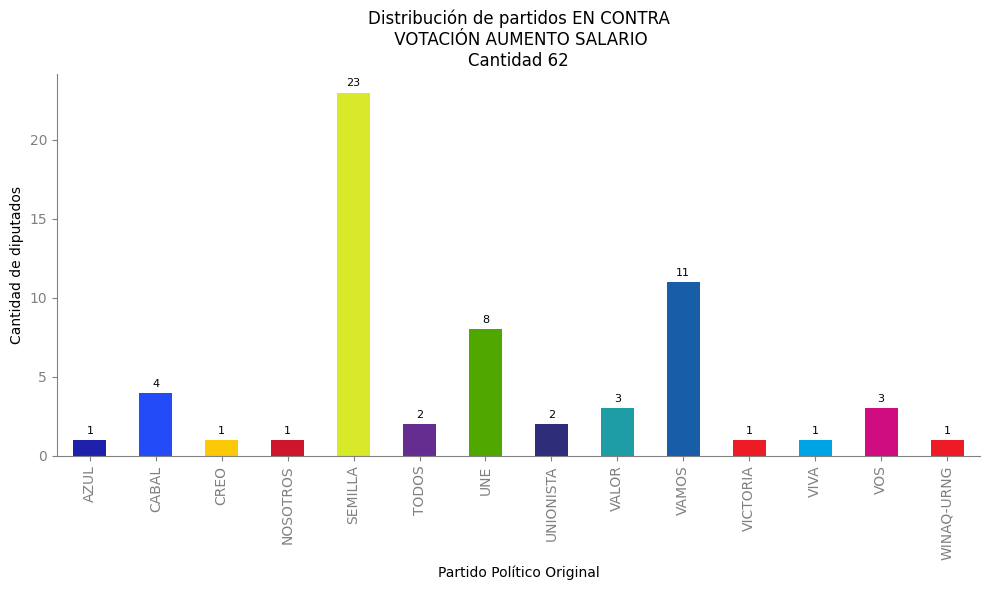

Grupo 1


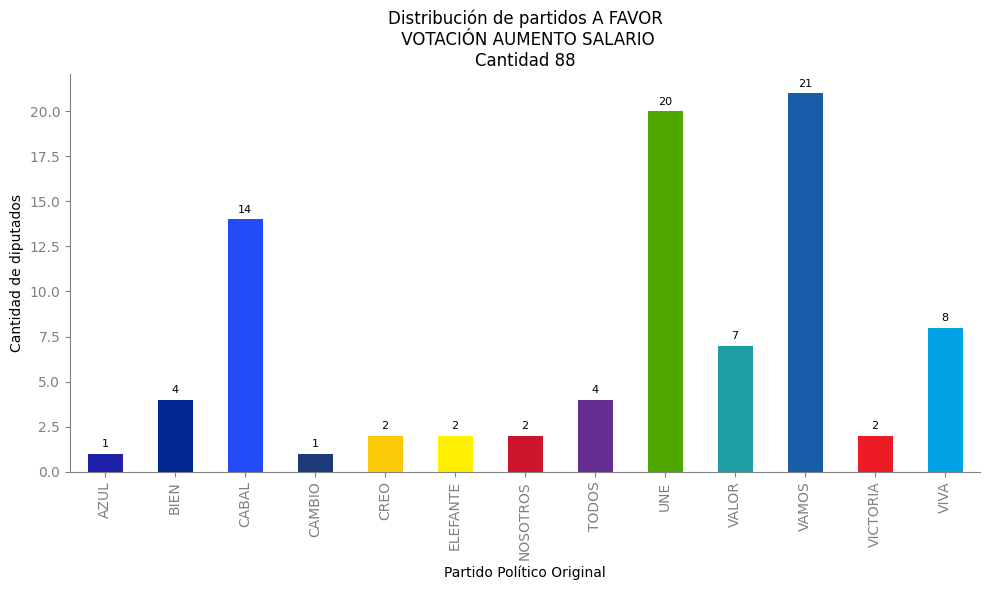

Grupo 2


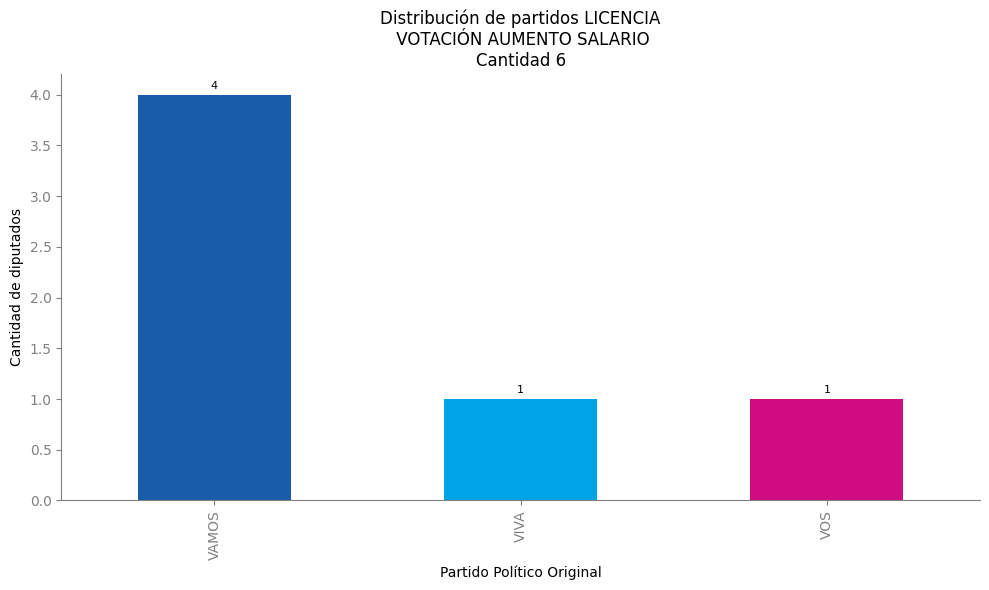

Grupo 3


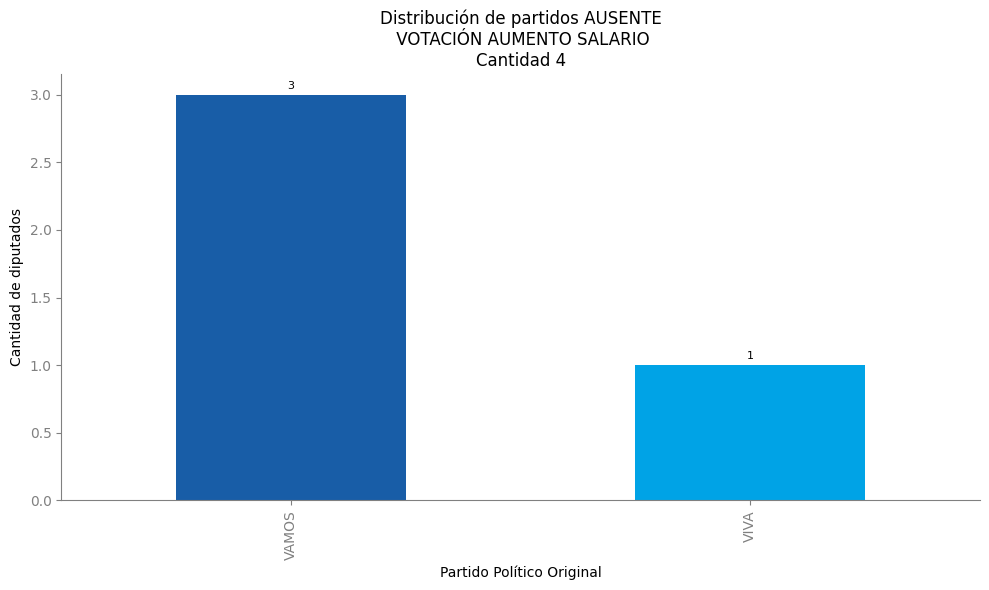

In [162]:
#Analizing groups
unique_groups = pivoted_2['Grupo'].astype(int).sort_values().unique()
unique_groups
group_mapper = {
    1: 'EN CONTRA',
    2: 'A FAVOR',
    3: 'LICENCIA',
    4: 'AUSENTE'
}
for i in unique_groups:
    print(f"Grupo {i}")
    current_group = pivoted_2[pivoted_2['Grupo'].astype(int) == i]
    showing_group = i + 1
    #Grouping by party
    party_group = current_group.groupby('NOMBRE CORTO').count().iloc[:, -1]
    plot_group_by_party(party_group, title = f'Distribución de partidos {group_mapper[int(i)+1]}\n VOTACIÓN AUMENTO SALARIO\nCantidad {len(current_group)}')
    generate_party_tables(current_group, showing_group, ['AZUL','BIEN'], group_mapper[showing_group])

# Análisis por departamento

In [163]:
#Distritos
distritos = pd.read_excel('../data/votos_procesado/temp/deptos.xlsx')
distritos = distritos[['Nombre','Distrito']]
#Asignando index
distritos = distritos.set_index('Nombre')
distritos.head()

,Distrito
Nombre,
Victor Alfredo Valenzuela Argueta,Lista Nacional
Mynor Alfonso De la Rosa Palacios,Lista Nacional
Héctor Adolfo Aldana Reyes,Lista Nacional
Ronald Yomelfy Portillo Cordón,Lista Nacional
Carlos Roberto Calderon Galvez,Lista Nacional


In [164]:
#Agregando distritos
pivoted_3 = pivoted_2.copy()
pivoted_3['Distrito'] = pivoted_3.index.map(distritos['Distrito'])
pivoted_3.head()

,S54_E44,Grupo,Event_Key,Pos,BLOQUE,BLOQUE ORIGINAL,NOMBRE,NOMBRE CORTO,Distrito
NOMBRE,,,,,,,,,
Héctor Adolfo Aldana Reyes,LICENCIA,2,Héctor Adolfo Aldana Reyes,1.0,VAMOS POR UNA GUATEMALA DIFERENTE,VAMOS POR UNA GUATEMALA DIFERENTE,Héctor Adolfo Aldana Reyes,VAMOS,Lista Nacional
Felipe Alejos Lorenzana,EN CONTRA,0,Felipe Alejos Lorenzana,1.0,TODOS,TODOS,Felipe Alejos Lorenzana,TODOS,Lista Nacional
Sergio David Arana Roca,AUSENTE,3,Sergio David Arana Roca,1.0,VAMOS POR UNA GUATEMALA DIFERENTE,VAMOS POR UNA GUATEMALA DIFERENTE,Sergio David Arana Roca,VAMOS,Escuintla
Luis Fernando Aguirre Estrada,A FAVOR,1,Luis Fernando Aguirre Estrada,1.0,CABAL,CABAL,Luis Fernando Aguirre Estrada,CABAL,Listado Nacional
Cristian Rodolfo Alvarez y Alvarez,EN CONTRA,0,Cristian Rodolfo Alvarez y Alvarez,2.0,"COMPROMISO, RENOVACIÓN Y ORDEN","COMPROMISO, RENOVACIÓN Y ORDEN",Cristian Rodolfo Alvarez y Alvarez,CREO,Distrito Central


In [165]:
#Seleccionando distritos = null
null_distritos = pivoted_3[pivoted_3['Distrito'].isnull()]
#null_distritos.to_excel('temp_null_dist.xlsx')
null_distritos.head()

,S54_E44,Grupo,Event_Key,Pos,BLOQUE,BLOQUE ORIGINAL,NOMBRE,NOMBRE CORTO,Distrito
NOMBRE,,,,,,,,,


In [166]:
def generate_district_tables(current_group, distrito, white_text_parties, group_mapper, party_colors, color_mapping):
    import os
    import pandas as pd
    import dataframe_image as dfi

    # Preparar DataFrame
    data = current_group[['PARTIDO', 'DIPUTADO', 'VOTO']].copy()
    #data.rename(columns={'GRUPO': 'VOTO'}, inplace=True)
    #data['VOTO'] = data['VOTO'].map(group_mapper)

    # Resetear índice para numeración de filas
    data.reset_index(drop=True, inplace=True)
    data.index = data.index + 1

    # Dividir DataFrame en chunks (4–10 filas por tabla)
    def split_dataframe_for_images(data):
        total_rows = len(data)
        possible_chunks = []
        for num_chunks in range(1, total_rows + 1):
            chunk_size = total_rows // num_chunks
            if 4 <= chunk_size <= 10:
                possible_chunks.append((num_chunks, chunk_size))
        if possible_chunks:
            best_chunks = min(possible_chunks, key=lambda x: abs(x[0] - 4))
            num_chunks = best_chunks[0]
        else:
            num_chunks = max(1, (total_rows + 9) // 10)
        chunk_size = (total_rows + num_chunks - 1) // num_chunks
        return [data[i:i + chunk_size] for i in range(0, total_rows, chunk_size)]

    chunks = split_dataframe_for_images(data)

    # Crear carpeta si no existe
    os.makedirs('tables_distrito', exist_ok=True)

    for idx, chunk in enumerate(chunks):
        def style_party(party):
            bg_color = party_colors.get(party, (0.784, 0.784, 0.784))  # default gray
            bg_color_rgb = f'rgb({int(bg_color[0]*255)}, {int(bg_color[1]*255)}, {int(bg_color[2]*255)})'
            text_color = 'white' if party in white_text_parties else 'black'
            return f'background-color: {bg_color_rgb}; color: {text_color};'

        def style_vote(voto):
            color = color_mapping.get(voto, 'black')
            return f'color: {color};'

        # Aplicar estilos
        styled = chunk.style.applymap(style_party, subset=['PARTIDO'])
        styled = styled.applymap(style_vote, subset=['VOTO'])
        styled = styled.set_caption(f'Distrito {distrito} - Tabla {idx + 1}')
        styled = styled.set_properties(**{
            'text-align': 'left',
            'font-size': '10pt'
        })
        styled.set_table_styles([
            {'selector': 'th', 'props': [('max-width', '200px')]},
            {'selector': 'td', 'props': [('max-width', '200px')]}
        ])

        # Exportar como imagen
        output_path = f'tables_distrito/distrito_{distrito}_tabla_{idx + 1}.png'
        dfi.export(styled, output_path, max_rows=-1, max_cols=-1, dpi=300)

In [167]:
pivoted_3.head()

,S54_E44,Grupo,Event_Key,Pos,BLOQUE,BLOQUE ORIGINAL,NOMBRE,NOMBRE CORTO,Distrito
NOMBRE,,,,,,,,,
Héctor Adolfo Aldana Reyes,LICENCIA,2,Héctor Adolfo Aldana Reyes,1.0,VAMOS POR UNA GUATEMALA DIFERENTE,VAMOS POR UNA GUATEMALA DIFERENTE,Héctor Adolfo Aldana Reyes,VAMOS,Lista Nacional
Felipe Alejos Lorenzana,EN CONTRA,0,Felipe Alejos Lorenzana,1.0,TODOS,TODOS,Felipe Alejos Lorenzana,TODOS,Lista Nacional
Sergio David Arana Roca,AUSENTE,3,Sergio David Arana Roca,1.0,VAMOS POR UNA GUATEMALA DIFERENTE,VAMOS POR UNA GUATEMALA DIFERENTE,Sergio David Arana Roca,VAMOS,Escuintla
Luis Fernando Aguirre Estrada,A FAVOR,1,Luis Fernando Aguirre Estrada,1.0,CABAL,CABAL,Luis Fernando Aguirre Estrada,CABAL,Listado Nacional
Cristian Rodolfo Alvarez y Alvarez,EN CONTRA,0,Cristian Rodolfo Alvarez y Alvarez,2.0,"COMPROMISO, RENOVACIÓN Y ORDEN","COMPROMISO, RENOVACIÓN Y ORDEN",Cristian Rodolfo Alvarez y Alvarez,CREO,Distrito Central


In [168]:
color_mapping = {
    'A FAVOR': 'green',
    'EN CONTRA': 'red',
    'AUSENTE': 'gray',
    'LICENCIA': 'gray'
}

#Renombrando
pivoted_3['PARTIDO'] = pivoted_3['NOMBRE CORTO']
pivoted_3['DIPUTADO'] = pivoted_3['NOMBRE']
pivoted_3['GRUPO'] = pivoted_3['Grupo'].map(group_mapper)
pivoted_3['VOTO'] = pivoted_3['S54_E44']

#Generando tablas
unique_districts = pivoted_3['Distrito'].unique()
for i in unique_districts:
    current_distrito = pivoted_3[pivoted_3['Distrito'] == i]
    print(f"Distrito {i}")
    #Grouping by party
    #party_group = current_group.groupby('PARTIDO').count().iloc[:, -1]
    generate_district_tables(current_distrito, i, ['AZUL','BIEN'], group_mapper, party_colors, color_mapping)

Distrito Lista Nacional
Distrito Escuintla
Distrito Listado Nacional
Distrito Distrito Central 
Distrito Guatemala
Distrito Chiquimula
Distrito Totonicapán
Distrito Quetzaltenango
Distrito Quiche
Distrito Distrito Central
Distrito Sololá
Distrito Suchitepéquez
Distrito Chimaltenango
Distrito El Progreso
Distrito Santa Rosa
Distrito Huehuetenango
Distrito Jutiapa
Distrito San Marcos
Distrito Sacatepéquez
Distrito Alta Verapaz
Distrito Peten
Distrito Jalapa
Distrito Retalhuleu
Distrito Baja Verapaz
Distrito Izabal
Distrito Zacapa
Distrito Lista Nacional 
